In [5]:
import QuantLib as ql
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# Preprocessing

In [6]:
clean_data = pd.read_csv('data/cleaned_price_data.csv')

clean_data["pd_QuoteDate"] = pd.to_datetime(clean_data["Quote Date"])

daily_df = {}
for date, group in clean_data.groupby("Quote Date"):
    daily_df[date] = group[['S','K','T','r','q','C','P']].reset_index(drop=True)

days = list(daily_df.keys())
pd_days = [pd.to_datetime(d).normalize() for d in days]

print(daily_df['2023-10-02'].shape)
print(daily_df['2023-10-02'].head())

(1000, 7)
        S      K         T         r      q       C      P
0  427.36  390.0  0.068493  0.043099  0.016  39.350  0.545
1  427.36  394.0  0.068493  0.043099  0.016  35.730  0.685
2  427.36  395.0  0.068493  0.043099  0.016  34.775  0.725
3  427.36  396.0  0.068493  0.043099  0.016  33.825  0.775
4  427.36  398.0  0.068493  0.043099  0.016  31.765  0.885


# Deamericanizing

In [7]:
import jax
import jax.numpy as jnp
import jax.scipy.stats.norm as jnorm
jax.config.update("jax_enable_x64", True)

def fast_black_scholes_call(S_0,K,T,sigma,r,q):
    srt = sigma*jnp.sqrt(T)
    d1 = (jnp.log(S_0/K)+(r-q+sigma**2/2)*T)/srt
    d2 = d1 - srt

    return S_0*jnp.exp(-q*T)*jnorm.cdf(d1) - K*jnp.exp(-r*T)*jnorm.cdf(d2)

def bbs_am_core(params,N):
    S_0,K,T,sigma,r,q = params

    delta = T/N
    u = jnp.exp(sigma*jnp.sqrt(delta))
    d = 1/u
    pstar = (jnp.exp((r-q)*delta)-d)/(u-d)
    disc = jnp.exp(-r*delta)

    # initialize S at step N-1
    i = jnp.arange(N)
    S = S_0 * u**(2*i - N + 1)

    # initialize V at step N-1 using black scholes
    continuing_val = fast_black_scholes_call(S, K, delta, sigma, r, q)
    V = jnp.maximum(continuing_val, S - K)

    def step(carry, _):
        V, S = carry

        S_new = S[:-1]*u
        continuing_val = (pstar * V[1:] + (1-pstar) * V[:-1]) * disc
        exercise_val = jnp.maximum(S_new-K,0)
        V_new = jnp.maximum(continuing_val,exercise_val)

        V = jnp.concatenate([V_new, jnp.zeros(1)], axis=0)
        S = jnp.concatenate([S_new, jnp.zeros(1)], axis=0)
        return (V, S), None

    (V_final,_),_ = jax.lax.scan(step, (V,S), length=N-1)
    return V_final[0]

def bbs_eur_core(params,N):
    S_0,K,T,sigma,r,q = params

    delta = T/N
    u = jnp.exp(sigma*jnp.sqrt(delta))
    d = 1/u
    pstar = (jnp.exp((r-q)*delta)-d)/(u-d)
    disc = jnp.exp(-r*delta)

    # initialize S at step N-1
    i = jnp.arange(N)
    S = S_0 * u**(2*i - N + 1)

    # initialize V at step N-1 using black scholes
    V = fast_black_scholes_call(S,K,delta,sigma,r,q)

    def step(carry, _):
        V, S = carry

        S_new = S[:-1]*u
        V_new = (pstar * V[1:] + (1-pstar) * V[:-1]) * disc

        V = jnp.concatenate([V_new, jnp.zeros(1)], axis=0)
        S = jnp.concatenate([S_new, jnp.zeros(1)], axis=0)
        return (V, S), None

    (V_final,_),_ = jax.lax.scan(step, (V,S), length=N-1)
    return V_final[0]

def bbsr_am_core(params,N):
    C1 = bbs_am_core(params,N//2)
    C2 = bbs_am_core(params,N)
    return(2*C2 - C1)

def bbsr_eur_core(params,N):
    C1 = bbs_eur_core(params,N//2)
    C2 = bbs_eur_core(params,N)
    return(2*C2 - C1)

bbsr_am_jit = jax.jit(bbsr_am_core,static_argnames='N')
bbsr_eur_jit = jax.jit(bbsr_eur_core,static_argnames='N')

bbsr_am_vmap = jax.jit(jax.vmap(bbsr_am_core,in_axes=(0,None)), static_argnames='N')
bbsr_eur_vmap = jax.jit(jax.vmap(bbsr_eur_core,in_axes=(0,None)), static_argnames='N')

def bbsr(params,option_type,exercise_type,N):
    if N%2!=0:
        raise ValueError("N must be even for BBSR")

    if option_type=='C':
        pass
    elif option_type=='P':
        S,K,T,sigma,r,q = params
        params = (K,S,T,sigma,q,r)
    else:
        raise ValueError("Invalid option type")

    if exercise_type=='A':
        price = bbsr_am_jit(params,N)
    elif exercise_type=='E':
        price = bbsr_eur_jit(params,N)
    else:
        raise ValueError("Invalid exercise type")
    return(price)

def bbsr_vector(param_array,option_type,exercise_type,N):
    if N%2!=0:
        raise ValueError("N must be even for BBSR")

    if option_type=='C':
        pass
    elif option_type=='P':
        param_array = param_array[:,[1,0,2,3,5,4]]
    else:
        raise ValueError("Invalid option type")

    if exercise_type=='A':
        price = bbsr_am_vmap(param_array,N)
    elif exercise_type=='E':
        price = bbsr_eur_vmap(param_array,N)
    else:
        raise ValueError("Invalid exercise type")
    return(price)

In [8]:
from scipy.optimize import brentq

def calibrate_vol_american(S_0, K, T, r, q, observed_price, option_type='C', bracket=(0.01, 1.0)):
    price_error = lambda sigma: bbsr((S_0, K, T, sigma, r, q), option_type, 'A', 200) - observed_price
    try:
        return brentq(price_error,bracket[0],bracket[1])
    except ValueError:
        return np.nan
    
def de_americanize_row(row, option_type='C', bracket=(0.01, 1.0)):
    S_0, K, T, r, q, C, P,*more  = row
    price = C if option_type=='C' else P
        
    sigma = calibrate_vol_american(S_0, K, T, r, q, price, option_type, bracket)

    return bbsr((S_0, K, T, sigma, r, q), option_type, 'E', 200)

def de_americanize(data, option_type='C', bracket=(0.01,1.0)):
    return np.array([de_americanize_row(row, option_type, bracket) for row in data])

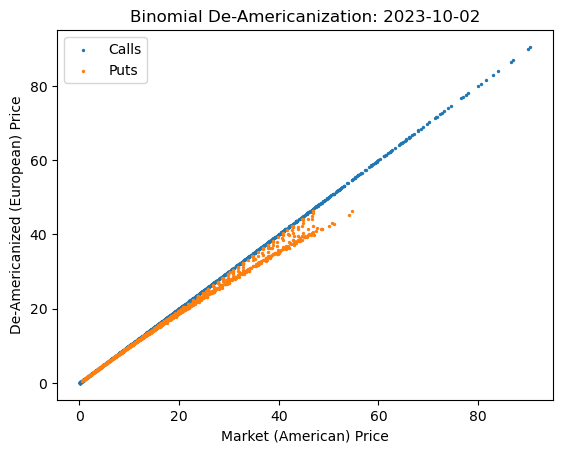

In [9]:
day = '2023-10-02'
actual_puts = daily_df[day]['P']
de_am_puts = de_americanize(daily_df[day].values, 'P', (0.05,0.50))

actual_calls = daily_df[day]['C']
de_am_calls = de_americanize(daily_df[day].values, 'C', (0.05,0.50))

plt.scatter(actual_calls, de_am_calls, s=2, label='Calls')
plt.scatter(actual_puts, de_am_puts, s=2, label='Puts')

plt.title(f'Binomial De-Americanization: {day}')
plt.xlabel('Market (American) Price')
plt.ylabel('De-Americanized (European) Price')

plt.legend()
plt.show()

In [10]:
from joblib import Parallel, delayed
def one_day(day):
    calls_euro = de_americanize(daily_df[day].values, 'C', (0.05,0.50))
    puts_euro = de_americanize(daily_df[day].values, 'P', (0.05,0.50))

    return (calls_euro, puts_euro)

de_americanized_prices = Parallel(n_jobs=-1)(
    delayed(one_day)(day) for day in days
)

In [12]:
for i in range(len(days)):
    day = days[i]
    daily_df[day]['C_euro'] = de_americanized_prices[i][0]
    daily_df[day]['P_euro'] = de_americanized_prices[i][1]

## Calibration

In [13]:
def build_zero_curve(maturities, zero_rates):
    tmp = []
    today = ql.Date().todaysDate()  
    for T, r in zip(maturities, zero_rates):
        d = today + int(round(T * 365))
        tmp.append((d, float(r)))

    tmp = sorted(set(tmp), key=lambda x: x[0]) # handle duplicates

    ql_dates, ql_rates = [today], [zero_rates[0]]
    for d, r in tmp:
        ql_dates.append(d)
        ql_rates.append(r)

    curve = ql.ZeroCurve(ql_dates, ql_rates, ql.Actual365Fixed())
    ts_handle = ql.YieldTermStructureHandle(curve)
    return ts_handle

def build_static_ql_objects(spot, maturities, rates, q):
    today = ql.Date().todaysDate()
    ql.Settings.instance().evaluationDate = today
    
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot))

    rf_curve = build_zero_curve(maturities, rates)
    
    div_curve = ql.YieldTermStructureHandle(
        ql.FlatForward(today, q, ql.Actual365Fixed()))

    return spot_handle, rf_curve, div_curve

def build_option_list(strikes, maturities, option_type, engine):
    today = ql.Date().todaysDate()
    option_type_ql = ql.Option.Call if option_type=='C' else ql.Option.Put
    
    option_list = []
    for K, T in zip(strikes, maturities):
        payoff = ql.PlainVanillaPayoff(option_type_ql, K)
        exercise = ql.EuropeanExercise(today + int(T * 365))
        option = ql.VanillaOption(payoff, exercise)
        
        option.setPricingEngine(engine)

        option_list.append(option)
    return option_list

In [63]:
#Optimized Heston Pricer - use the same model, just rewrite params
def calibration_objective(params, prices, option_list, model):
    ql_params = ql.Array(params.tolist())
    model.setParams(ql_params)
    engine = ql.AnalyticHestonEngine(model, 32)
    for opt in option_list:
        opt.setPricingEngine(engine)

    model_prices = np.array([opt.NPV() for opt in option_list])

    return np.sum(((model_prices - prices)/prices)**2)

#Main Calibration Function
def calibrate_heston(data):
    spot = data[0,0]
    q = 0.016

    call_prices = data[:,7]
    put_prices = data[:,8]
    nan_idx = np.isnan(call_prices) | np.isnan(put_prices)

    call_prices = call_prices[~nan_idx]
    put_prices = put_prices[~nan_idx]
    data_clean = data[~nan_idx]

    strikes = data_clean[:,1]
    maturities = data_clean[:,2]
    rates = data_clean[:,3]
    
    spot_handle, rf_curve, div_curve = build_static_ql_objects(spot, maturities, rates, q)

    initial_guess = np.array([1.0, 0.05, 0.3, -0.6, 0.02])
    kappa, theta, sigma, rho, v0 = initial_guess

    bounds = [
        (0.01, 10),      # kappa
        (0.01, 10),    # theta
        (0.01, 3),      # sigma
        (-0.99, 0),     # rho
        (0.01, 0.5)     # v0
    ]

    heston_process = ql.HestonProcess(
        rf_curve, div_curve, spot_handle,
        v0, kappa, theta, sigma, rho
    )

    model = ql.HestonModel(heston_process)
    engine = ql.AnalyticHestonEngine(model, 32)
    calls = build_option_list(strikes, maturities, 'C', engine)
    puts = build_option_list(strikes, maturities, 'P', engine)
    option_list = calls + puts
    prices = np.concatenate([call_prices, put_prices])

    result = minimize(
        calibration_objective,
        initial_guess,
        args=(prices, option_list, model),
        bounds=bounds,
        method="L-BFGS-B")

    return result.x, result.fun

In [64]:
day = '2023-10-02'
data = daily_df[day].values

start = time.time()
calibrated_params, err = calibrate_heston(data)
stop = time.time()

params = pd.Series(calibrated_params, index=['kappa','theta','sigma','rho','v0'])

print(f"Calibration completed in {stop-start:.2f} seconds\n")

print("Calibrated Parameters:")
print(params.to_string())

print(f"\nCalibration Error: {err:.4f}")
print(f"RMSE: {np.sqrt(err/len(daily_df[day])):.4f}")

Calibration completed in 3.74 seconds

Calibrated Parameters:
kappa    0.902010
theta    0.040001
sigma    0.559211
rho     -0.682225
v0       0.026480

Calibration Error: 8.6575
RMSE: 0.0930


In [16]:
from joblib import Parallel, delayed

results = Parallel(n_jobs=-1)(
    delayed(calibrate_heston)(daily_df[day].values)
    for day in days
)

Average RMSE: 0.1212


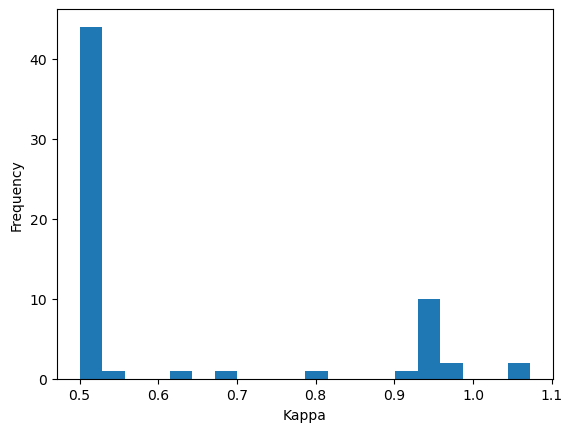

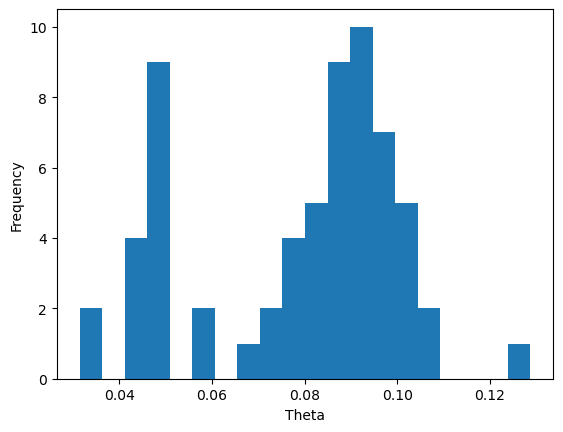

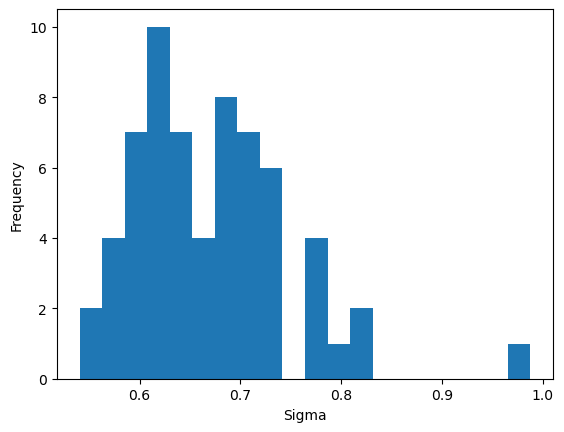

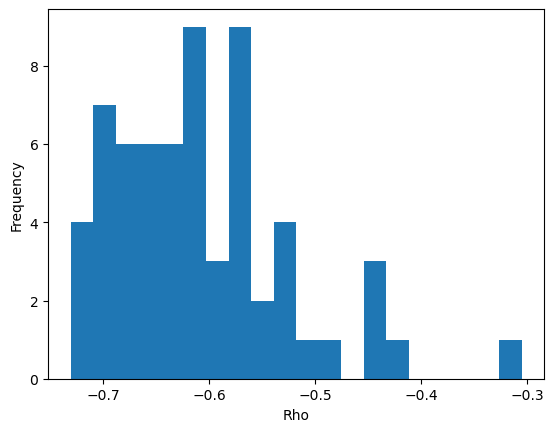

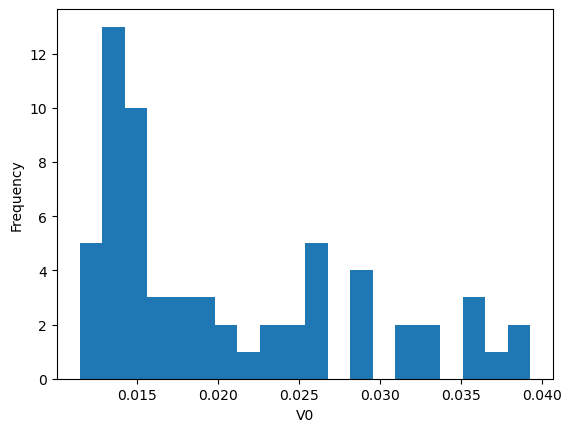

In [17]:
params = [np.array(res[0]) for res in results]
errors = [res[1] for res in results]
res = pd.DataFrame(np.array(params))
res.columns = ['kappa','theta','sigma','rho','v0']

avg_rmse = np.mean([np.sqrt(err/daily_df[day].shape[0]) for err, day in zip(errors, days)])
print(f"Average RMSE: {avg_rmse:.4f}")
for col in res.columns:
    plt.hist(res[col],bins=20)

    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    plt.show()

# Surface Visualization

In [90]:
def price_matrix_quantlib(S0, r, q, heston_params, strikes, maturities):
    import QuantLib as ql
    kappa, theta, sigma, rho, v0 = heston_params

    today = ql.Date.todaysDate()
    ql.Settings.instance().evaluationDate = today

    prices = np.zeros((len(maturities), len(strikes)))
    # construct curve objects
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    div_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, q, ql.Actual365Fixed()))
    spot = ql.QuoteHandle(ql.SimpleQuote(S0))

    # Heston process & model
    process = ql.HestonProcess(flat_ts, div_ts, spot, v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)

    for i, T in enumerate(maturities):
        maturity_date = today + int(round(T * 365))
        exercise = ql.EuropeanExercise(maturity_date)
        for j, K in enumerate(strikes):
            option = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, K), exercise)
            engine = ql.AnalyticHestonEngine(model)
            option.setPricingEngine(engine)
            prices[i, j] = option.NPV()
    return prices

def implied_vol_from_price(price, S, K, T, r, q):
    from scipy.stats import norm
    from scipy.optimize import brentq
    import numpy as np
    import math

    def bs_call(S, K, T, r, q, vol):
        if T <= 0 or vol <= 0:
            return max(S*np.exp(-q*T) - K*np.exp(-r*T), 0)
        d1 = (math.log(S/K) + (r - q + 0.5*vol*vol)*T) / (vol*math.sqrt(T))
        d2 = d1 - vol*math.sqrt(T)
        return S*math.exp(-q*T)*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)

    intrinsic = max(S*np.exp(-q*T) - K*np.exp(-r*T), 0)

    # enforce European-arbitrage bounds
    price = max(price, intrinsic + 1e-12)

    try:
        return brentq(
            lambda vol: bs_call(S, K, T, r, q, vol) - price,
            1e-6, 5.0, maxiter=200
        )
    except:
        return np.nan

def compute_iv_surface(S0, r, q, heston_params, strikes, maturities):
    prices = price_matrix_quantlib(S0, r, q, heston_params, strikes, maturities)

    # convert prices to IVs
    ivs = np.zeros_like(prices)
    for i, T in enumerate(maturities):
        for j, K in enumerate(strikes):
            price = prices[i, j]
            ivs[i, j] = implied_vol_from_price(price, S0, K, T, r, q)
    return ivs

def plot_iv_surface(strikes, maturities, ivs, S0):
    K_grid, T_grid = np.meshgrid(strikes, maturities)
    fig = plt.figure(figsize=(14, 6))

    # 3D surface
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.view_init(elev=30, azim=135) 
    surf = ax.plot_surface(K_grid, T_grid, ivs, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Strike (K)')
    ax.set_ylabel('Maturity (T, years)')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(f'Heston implied vol surface')
    fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1)

    plt.tight_layout()
    plt.show()

def iv_surface_pipeline(day):
    print('Calibrating...')
    heston_params, error = calibrate_heston(daily_df[day].values)
    S0 = daily_df[day]['S'][0]

    print('Generating Surface...')
    strikes = np.linspace(0.7 * S0, 1.3 * S0, 50)
    maturities = np.linspace(0.05, 1, 50)
    surface = compute_iv_surface(100, 0.06, 0.016, heston_params, strikes, maturities)

    print("Plotting Surface...")
    plot_iv_surface(strikes, maturities, surface, S0)

Calibrating...
Generating Surface...
Plotting Surface...


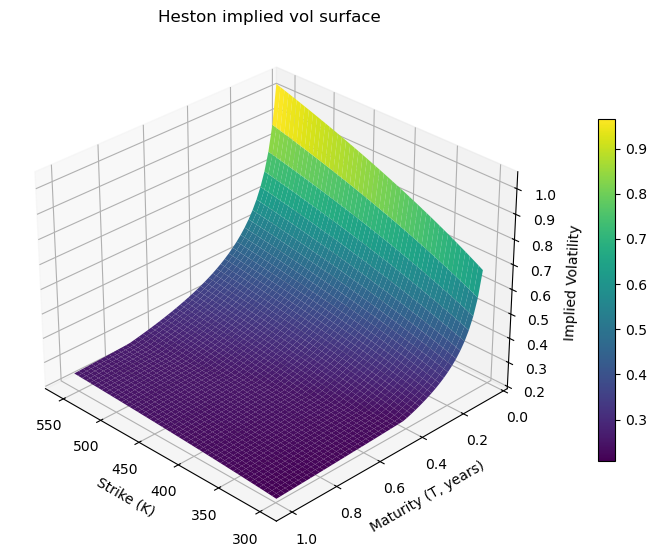

In [95]:
iv_surface_pipeline('2023-10-02')